In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

# Utilities for plotting
import sys
sys.path.append("../")
from utils.plotting import plot_stt, plot_isochrones_with_pid, plot_particleIDs_and_trackIDs

In [2]:
event_num = 1457
input_dir = f"/home/nikin105/mlProject/data/machineLearning/mum5mup5/classification/layerwise_100k/test/{event_num}"
input_dir2 = f"/home/nikin105/mlProject/data/machineLearning/mum5mup5/evaluation/mum5mup5/layerwise_100k/{event_num}"
data = torch.load(input_dir,map_location=torch.device('cpu'))
data2 = torch.load(input_dir2,map_location=torch.device('cpu'))
save_figs = True
image_dir = "/home/nikin105/sciebo/Doktor/ML-Project/Images/machineLearning/mum5mup5/layerwise_100k/track_building/"

# Convert hit positions from scaled polar coordinates to cartesian coordinates
r = data.x[:, 0].detach().numpy() * 42
phi = data.x[:, 1].detach().numpy() * 2 * np.pi
isochrones = data.x[:, 2].detach().numpy() * 0.5

x = r * np.cos(phi)
y = r * np.sin(phi)

# Get the number of hits
n_hits = len(data.x)

# Prepare the colors for the different pids
pid_color_palette = sns.color_palette("tab20")
tid_color_palette = sns.color_palette("tab20")

# Rename some variables for better readability
gt = data.true_edges
input_edges = data.edge_index
edge_labels = data.y_pid
hid = data.hid
pids = data.pid
pdg_codes = data.pdgcode

# Get true and false input edges
true_input_edges = input_edges[:, edge_labels == 1]
false_input_edges = input_edges[:, edge_labels == 0]

# Get the unique particle ids
unique_pids = np.unique(pids)

# Get the number of multi hits per hit
n_multi_hits = data.n_multi_hits

# Get the pids of the multi hits
multi_hit_pids = data.multi_hit_particle_ids

In [3]:
data_df = pd.DataFrame({"x": x, "y": y, "pid": pids, "hit_id": hid})
data_df = pd.merge(data_df, data2, on="hit_id").reset_index(drop=True)
data_df.head()

,x,y,pid,hit_id,track_id
0,16.619032,-6.564993,9,0,0
1,17.493713,-6.059997,9,1,0
2,17.493715,-7.069997,9,2,0
3,18.368401,-6.564995,9,3,0
4,18.368401,-7.574999,9,4,0


In [ ]:
n_multi_hits = np.ones(n_hits)
multi_hit_tids = np.zeros((n_hits,1), dtype=int).tolist()

supp_hits = []

for i, row in enumerate(data_df.itsertuples()):
    for j, row2 in enumerate(data_df.itertuples()):
        if j <= i:
            continue
        elif abs(row.x - row2.x) < 1e-6 and abs(row.y - row2.y) < 1e-6:
            multi_hit_pids[row.hit_id][0] = row.pid
            multi_hit_tids[row.hit_id][0] = row.track_id
            multi_hit_pids[row.hit_id].append(row2.pid)
            multi_hit_tids[row.hit_id].append(row2.track_id)
            n_multi_hits[row.hit_id] += 1
            supp_hits.append(row2.hit_id)


Saving figure to /home/nikin105/sciebo/Doktor/ML-Project/Images/machineLearning/mum5mup5/layerwise_100k/track_building//tracks_1457.png
Saving figure to /home/nikin105/sciebo/Doktor/ML-Project/Images/machineLearning/mum5mup5/layerwise_100k/track_building//tracks_1457.pdf


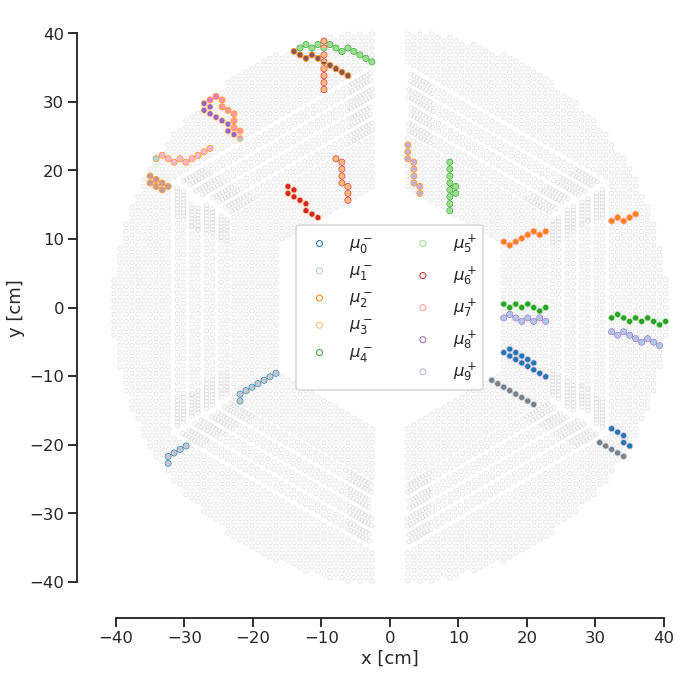

In [5]:
# prepare isochrones for the plot
isochrone_circles, legend_handles = plot_particleIDs_and_trackIDs(
    x,
    y,
    n_multi_hits,
    multi_hit_pids,
    multi_hit_tids,
    hid,
    pids,
    data_df.track_id.to_numpy(),
    unique_pids,
    pdg_codes,
    pid_color_palette,
    tid_color_palette,
    supp_hits,
)

fig, ax = plot_stt(useGrayScale=True, alpha=0.5)

# plot nodes
for circle in isochrone_circles:
    ax.add_artist(circle)

ax.legend(handles=legend_handles, loc="center", ncol=2)
fig.tight_layout()

if save_figs:
    print(f"Saving figure to {image_dir}/tracks_{event_num}.png")
    plt.savefig(f"{image_dir}/tracks_{event_num}.png", dpi=300)
    print(f"Saving figure to {image_dir}/tracks_{event_num}.pdf")
    plt.savefig(f"{image_dir}/tracks_{event_num}.pdf", dpi=300)
else:
    plt.show()